In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cosmic.fengines import ant_remotefeng_map # Map antenna numbers to FPGA cards
from cosmic.hashpipe_aux import redis_obj # Redis interface

ANTENNA_NAME = 'ea13'

In [2]:
# First, create an interface to a running F-engine pipeline
# You can do this by antenna name
# But you'll need a connection to the site redis server
fengs = ant_remotefeng_map.get_antennaFengineDict(redis_obj, antname_filter=[ANTENNA_NAME])
feng = fengs[ANTENNA_NAME]

In [3]:
# The blocks in the diagram above can be accessed through Fengine attributes
# Eg. print basic FPGA status information
feng.fpga.print_status()

 - fw_build_time: 2022-08-03T18:56:20
 - fw_type: 2
 - fw_version: 13.4.0.0
 - host: cosmic-fpga-1:pcie43
 - programmed: True
 - sw_version: 0.0.1
 - sys_mon: not reporting
 - timestamp: 2022-08-17T09:14:42.134357


In [4]:
LANE_MAP_0 = [0,1,3,7,6,8,2,4,5,9,11,10]
LANE_MAP_1 = [4,5,7,3,2,8,6,0,1,9,11,10]
REPEAT_DTS=True # Repeat IF "A" input over all IFs "A", "B", "C", "D"
# If your board is configured (because you are taking data) you shouldn't do this
# But if it hasn't been initialized outside of this notebook...
feng.initialize(read_only=False)
if feng.pipeline_id == 0:
    if REPEAT_DTS:
        feng.dts.set_lane_map(LANE_MAP_0[0:3]*4)
    else:
        feng.dts.set_lane_map(LANE_MAP_0)
else:
    if REPEAT_DTS:
        feng.dts.set_lane_map(LANE_MAP_1[0:3]*4)
    else:
        feng.dts.set_lane_map(LANE_MAP_1)
print(feng.dts.get_lane_ids())
feng.dts.align_lanes()
feng.sync.arm_sync()

Initializing block (writable): dts
Initializing block (writable): fpga
Initializing block (writable): sync
Initializing block (writable): delay
Initializing block (writable): lo
Initializing block (writable): noisegen
Initializing block (writable): sinegen
Initializing block (writable): input
Initializing block (writable): qsfp_a
Initializing block (writable): qsfp_b
Initializing block (writable): qsfp_c
Initializing block (writable): qsfp_d
Initializing block (writable): pfb
Initializing block (writable): autocorr
Initializing block (writable): eq
Initializing block (writable): eqtvg
Initializing block (writable): corr
Initializing block (writable): chanreorder
Initializing block (writable): eth0
Performing software global reset
pipeline0_dts - Setting lane map to [0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3]
[11, 12, 11, 13, 12, 13, 12, 11, 13, 11, 13, 12]
pipeline0_dts - Reference: first sync at 10
pipeline0_dts - Reference: first post-sync at 11
pipeline0_dts - Reference: Second (reference)

In [5]:
feng.input.print_status()

pipeline0_input - mean00: -2.6439456939697266
pipeline0_input - mean01: -2.6439456939697266
pipeline0_input - mean02: -2.6439456939697266
pipeline0_input - mean03: -2.6439456939697266
pipeline0_input - power00: 782.0236968994141
pipeline0_input - power01: 782.0236968994141
pipeline0_input - power02: 782.0236968994141
pipeline0_input - power03: 782.0236968994141
pipeline0_input - rms00: 27.964686604705836
pipeline0_input - rms01: 27.964686604705836
pipeline0_input - rms02: 27.964686604705836
pipeline0_input - rms03: 27.964686604705836
pipeline0_input - switch_position00: adc
pipeline0_input - switch_position01: adc
pipeline0_input - switch_position02: adc
pipeline0_input - switch_position03: adc


In [6]:
def plot_autos(feng, subplots=False, start_chan=0, stop_chan=-1):
    x = feng.autocorr.get_new_spectra()
    n_inputs = x.shape[0]
    acc_len = feng.autocorr.get_acc_len()
    plt.title('Aucorrelations (acc len %d)' % acc_len)
    for i in range(n_inputs):
        if subplots:
            plt.subplot(n_inputs, 1, i+1)
        plt.plot(10*np.log10(x[i][start_chan:stop_chan]), label=i)
        if subplots or i == (n_inputs-1):
            plt.legend()
            plt.ylabel('Power [dB arb. ref]')
    plt.xlabel('Frequency Channel')
    plt.show()

    

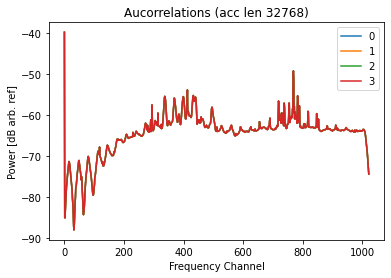

In [7]:
plot_autos(feng)

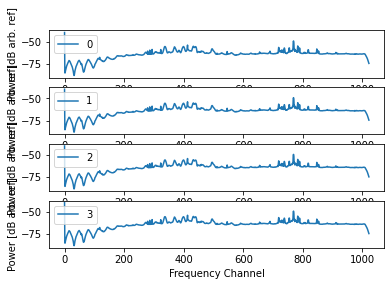

In [8]:
plot_autos(feng, subplots=True)

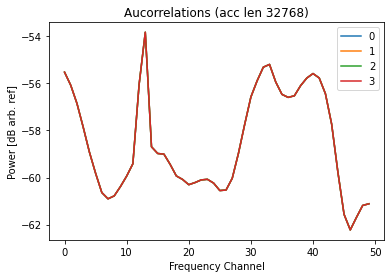

In [9]:
plot_autos(feng, start_chan=400, stop_chan=450)

In [10]:
# LO shift first input by 2 bins
feng.lo.set_lo_frequency_shift(0, 2000000)

pipeline0_lo - Setting lo phase offset of stream 0 to 4194304.0
pipeline0_lo - Setting lo phase step of stream 0 to 33554432.0


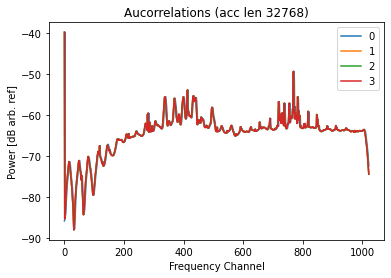

In [11]:
plot_autos(feng)

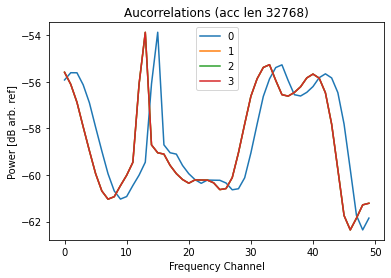

In [12]:
plot_autos(feng, start_chan=400, stop_chan=450)

In [13]:
# LO shift second input by -1 bin
feng.lo.set_lo_frequency_shift(1, -1000000)

pipeline0_lo - Setting lo phase offset of stream 1 to -2097152.0
pipeline0_lo - Setting lo phase step of stream 1 to -16777216.0


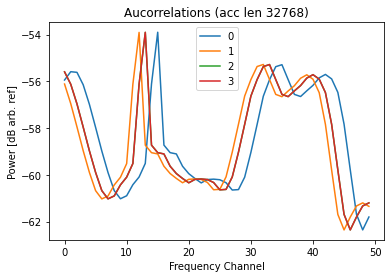

In [14]:
plot_autos(feng, start_chan=400, stop_chan=450)

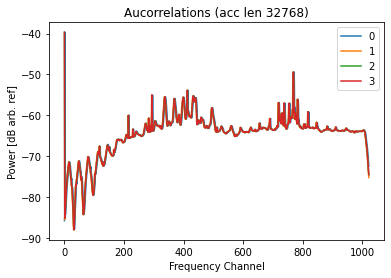

In [15]:
plot_autos(feng)

In [16]:
#So, the autocorrelation spectrum seems to behave as it should

In [17]:
#Shift 3rd input by +0.3 bins
feng.lo.set_lo_frequency_shift(2, 300000)

pipeline0_lo - Setting lo phase offset of stream 2 to 629145.6
pipeline0_lo - Setting lo phase step of stream 2 to 5033164.8


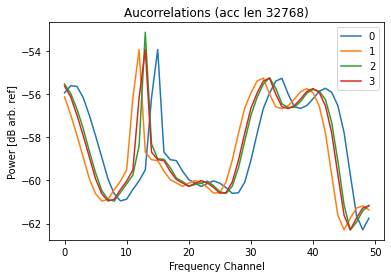

In [18]:
plot_autos(feng, start_chan=400, stop_chan=450)

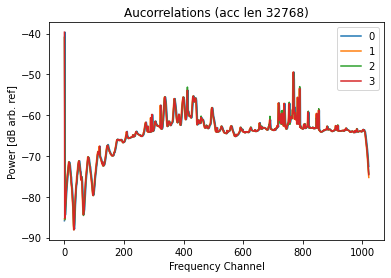

In [19]:
plot_autos(feng)

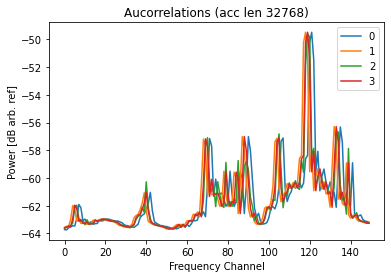

In [20]:
plot_autos(feng, start_chan=650, stop_chan=800)

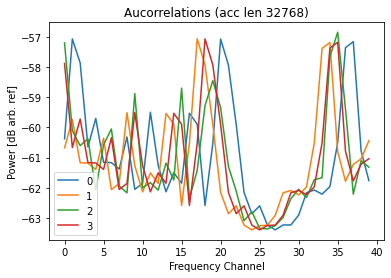

In [21]:
plot_autos(feng, start_chan=720, stop_chan=760)

In [23]:
# I think this is probably reasonable. Certainly the spectrum isn't completely mangled by a sub-bin-width shift

A dump of current observation info

baseband
["AC_8BIT", "BD_8BIT"]
datasetid
"20A-346.sb42432794.eb42529192.59808.23489403936"
dec_deg
30.44151278006118
fcents
[1320.257837512062, 1500.0]
fenchan
1024.0
fenpol
2
ifids
["AC", "BD"]
intents
{"RestFreqA0C0": "1420405752", "ProjectID": "38078528", "schedBlockStart": "Wed Aug 17 05:43:06 UTC 2022", "ObserverName": "Adam K. Leroy", "SBID": "42432794", "RestFrame": "LLLL", "VelocityA0C0": "-180000", "SBTYPE": "OBSERVER", "FreqVelSwitch": "VVVV", "ScanIntent": "OBSERVE_TARGET", "ObsCode": "20A-346", "ExecBlockID": "42529192", "schedBlockEnd": "Wed Aug 17 09:39:27 UTC 2022", "VLITE_OFF": "0"}
mjd
"59808"
nant
27
nbits
8
obsbwmhz
[1024.0, 1024.0]
projid
"38078528"
ra_deg
23.659908331229964
samplehz
2048000000.0
scanid
"20A-346.sb42432794.eb42529192.59808.23489403936.55.1"
sideband
[1, 1]
src
"M33_14"
sslo
[808.257837512062, 988.0]
station
["ea14", "ea13", "ea12", "ea11", "ea10", "ea28", "ea27", "ea26", "ea25", "ea24", "ea23", "ea22", "ea21", "ea09", "ea08", "ea07", "ea06", "ea05", "ea04", "ea03", "ea02", "ea01", "ea19", "ea18", "ea17", "ea16", "ea15"]
tbin
1e-06
tend
59808.387168981484
tnow
59808.384168173565
tstart
59808.38416782407

In [25]:
# Now set IF A to have no shift, an IF C (2nd pol of first firmware tuning) to have shift of 1 bin
feng.lo.set_lo_frequency_shift(0,0)
feng.lo.set_lo_frequency_shift(1,1000000)
feng.lo.set_lo_frequency_shift(2,0)
feng.lo.set_lo_frequency_shift(3,0)

feng.sync.arm_sync() # I think this is necessary when loading a shift which wan't previously zero

pipeline0_lo - Setting lo phase offset of stream 0 to 0.0
pipeline0_lo - Setting lo phase step of stream 0 to 0.0
pipeline0_lo - Setting lo phase offset of stream 1 to 2097152.0
pipeline0_lo - Setting lo phase step of stream 1 to 16777216.0
pipeline0_lo - Setting lo phase offset of stream 2 to 0.0
pipeline0_lo - Setting lo phase step of stream 2 to 0.0
pipeline0_lo - Setting lo phase offset of stream 3 to 0.0
pipeline0_lo - Setting lo phase step of stream 3 to 0.0


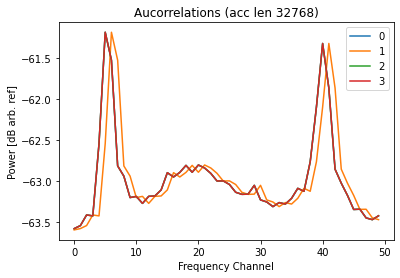

In [27]:
plot_autos(feng, start_chan=650, stop_chan=700)

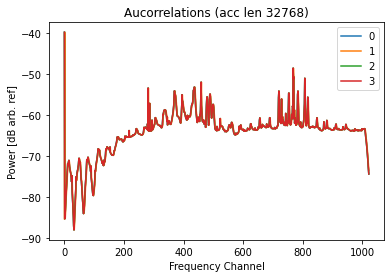

In [28]:
plot_autos(feng)

# .raw file tests

In [104]:
# Let's try to do some similar tests running data all the way through to raw files
# As cosmic, on cosmic-head: configure_remotefpga.py --config-file /home/cosmic/dev/jh/vla_f_config_a13_repeat_if.yaml
# This transmits full band of Antenna 13, with IFs repeated as in the above test.
# Right now, VLA is observing at 22.5 GHz

In [30]:
# Check the configuration
import numpy as np
from matplotlib import pyplot as plt
from cosmic.fengines import ant_remotefeng_map # Map antenna numbers to FPGA cards
from cosmic.hashpipe_aux import redis_obj # Redis interface

ANTENNA_NAME = 'ea13'
fengs = ant_remotefeng_map.get_antennaFengineDict(redis_obj, antname_filter=[ANTENNA_NAME])
feng = fengs[ANTENNA_NAME]

In [32]:
def plot_autos(feng, subplots=False, start_chan=0, stop_chan=-1):
    x = feng.autocorr.get_new_spectra()
    n_inputs = x.shape[0]
    acc_len = feng.autocorr.get_acc_len()
    plt.title('Aucorrelations (acc len %d)' % acc_len)
    for i in range(n_inputs):
        if subplots:
            plt.subplot(n_inputs, 1, i+1)
        plt.plot(10*np.log10(x[i][start_chan:stop_chan]), label=i)
        if subplots or i == (n_inputs-1):
            plt.legend()
            plt.ylabel('Power [dB arb. ref]')
    plt.xlabel('Frequency Channel')
    plt.show()


/tmp/ipykernel_1682275/2995372750.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


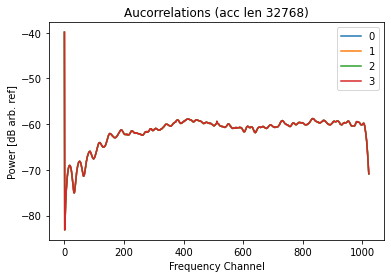

In [83]:
plot_autos(feng)

In [59]:
for i in range(4): print(feng.lo.get_lo_frequency_shift(i))

[0, 0.476837158203125]
[0, 0.476837158203125]
[0, 0.476837158203125]
[0, 0.476837158203125]


In [61]:
x, _ = feng.get_status_all(); print(x['eth0']) # Don't think overflows reported here are real...

{'tx_of': 2302586128, 'tx_full': 1640261122, 'tx_vld': 1388318065, 'tx_ctr': 1388318098}


In [62]:
# Start observation: start_observation.py -i 5 -n 1 -k PROJID=jackhtest
# File generated is /mnt/buf0/jackhtest/GUPPI/guppi_59808_40498_101363213989_tmc_row2_11_0001.0000.raw

In [124]:
def read_raw(fname):
    import blimpy
    gr = blimpy.GuppiRaw(fname)
    h, d = gr.read_next_data_block()
    x = d[:,0::2,0]
    y = d[:,1::2,0]
    return x,y

def average_pow(x,y):
    xx = x * np.conj(x)
    yy = y * np.conj(y)
    xy = x * np.conj(y)
    return xx.sum(axis=1), yy.sum(axis=1), xy.sum(axis=1)

def read_and_plot(fname, start_chan=0, stop_chan=-1, include_xy=True):
    x,y = read_raw(fname)
    xx, yy, xy = average_pow(x[start_chan:stop_chan],y[start_chan:stop_chan])
    if include_xy:
        plt.subplot(2,1,1)
    plt.plot(10*np.log10(xx.real), label='xx')
    plt.plot(10*np.log10(yy.real), label='yy')
    if include_xy:
        plt.plot(10*np.log10(np.abs(xy)), label='xy')
    plt.legend()
    if include_xy:
        plt.subplot(2,1,2)
        plt.plot(np.angle(xy), label='angle(xy)')
        plt.legend()
    #plt.show()
    
def upchan(d, upchan_factor=128):
    nchan, ntime = d.shape
    assert ntime % upchan_factor == 0
    dr = d.reshape(nchan, ntime // upchan_factor, upchan_factor)
    DR = np.fft.fft(dr, axis=2)
    DRR = DR.transpose(0,2,1).reshape(nchan*upchan_factor, ntime//upchan_factor)
    return DRR
    

/tmp/ipykernel_1682275/812051788.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


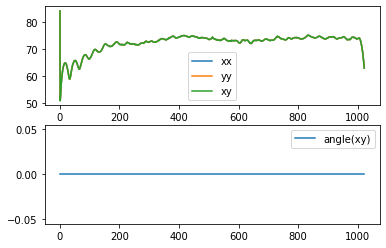

In [114]:
read_and_plot('/home/jackh/guppi_59808_40498_101363213989_tmc_row2_11_0001.0000.raw')

X max in channel 512
Y max in channel 512
Bin offset: 0
Freq offset: 0.0 kHz (resolution 1.95 kHz)


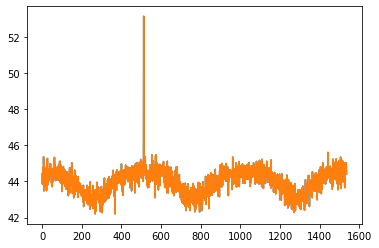

In [149]:
x, y = read_raw('/home/jackh/guppi_59808_40498_101363213989_tmc_row2_11_0001.0000.raw')
upchan_factor = 512
xup = upchan(x[511:514,:], upchan_factor)
yup = upchan(y[511:514,:], upchan_factor)
xdb = 10*np.log10(np.abs(xup).sum(axis=1))
ydb = 10*np.log10(np.abs(yup).sum(axis=1))

xmaxi = np.argmax(xdb)
ymaxi = np.argmax(ydb)
print('X max in channel %d' % xmaxi)
print('Y max in channel %d' % ymaxi)
delta_bin = xmaxi - ymaxi
rbw = 1e6 / upchan_factor # Hz
delta_f = delta_bin * rbw
print('Bin offset: %d' % delta_bin)
print('Freq offset: %.1f kHz (resolution %.2f kHz)' %(delta_f/1e3, rbw/1e3))
plt.plot(xdb)
plt.plot(ydb)

In [85]:
# Now shift X by 1 bin and take data again
feng.lo.set_lo_frequency_shift(0, 1000000)

pipeline0_lo - Setting lo phase offset of stream 0 to 2097152.0
pipeline0_lo - Setting lo phase step of stream 0 to 16777216.0


/tmp/ipykernel_1682275/812051788.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


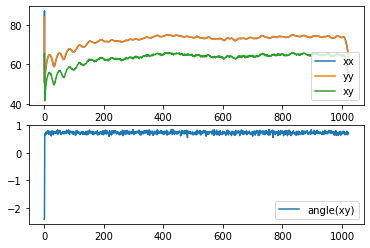

In [115]:
# Data file is guppi_59808_41405_101363269348_J0438+3004_0001.0000.raw
read_and_plot('/home/jackh/guppi_59808_41405_101363269348_J0438+3004_0001.0000.raw')

/tmp/ipykernel_1682275/812051788.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


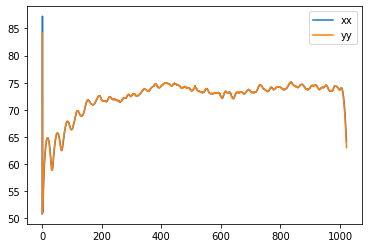

In [116]:
read_and_plot('/home/jackh/guppi_59808_41405_101363269348_J0438+3004_0001.0000.raw', include_xy=False)

/tmp/ipykernel_1682275/812051788.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


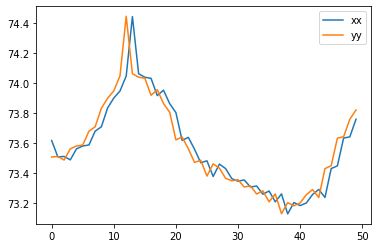

In [117]:
read_and_plot('/home/jackh/guppi_59808_41405_101363269348_J0438+3004_0001.0000.raw', include_xy=False, start_chan=500, stop_chan=550)

X max in channel 1024
Y max in channel 512
Bin offset: 512
Freq offset: 1000.0 kHz (resolution 1.95 kHz)


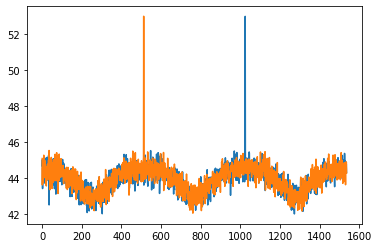

In [148]:
x, y = read_raw('/home/jackh/guppi_59808_41405_101363269348_J0438+3004_0001.0000.raw')
upchan_factor = 512
xup = upchan(x[511:514,:], upchan_factor)
yup = upchan(y[511:514,:], upchan_factor)
xdb = 10*np.log10(np.abs(xup).sum(axis=1))
ydb = 10*np.log10(np.abs(yup).sum(axis=1))

xmaxi = np.argmax(xdb)
ymaxi = np.argmax(ydb)
print('X max in channel %d' % xmaxi)
print('Y max in channel %d' % ymaxi)
delta_bin = xmaxi - ymaxi
rbw = 1e6 / upchan_factor # Hz
delta_f = delta_bin * rbw
print('Bin offset: %d' % delta_bin)
print('Freq offset: %.1f kHz (resolution %.2f kHz)' %(delta_f/1e3, rbw/1e3))
plt.plot(xdb)
plt.plot(ydb)

In [105]:
# Reconfigure FPGA (to resync and set LO shifts bback to 0)
# As cosmic, on cosmic-head: configure_remotefpga.py --config-file /home/cosmic/dev/jh/vla_f_config_a13_repeat_if.yaml


In [106]:
for i in range(4): print(feng.lo.get_lo_frequency_shift(i))

[0, 0.476837158203125]
[0, 0.476837158203125]
[0, 0.476837158203125]
[0, 0.476837158203125]


In [108]:
feng.lo.set_lo_frequency_shift(0, 100000) # 100kHz (0.1 of a bin) offset

pipeline0_lo - Setting lo phase offset of stream 0 to 209715.2
pipeline0_lo - Setting lo phase step of stream 0 to 1677721.6


/tmp/ipykernel_1682275/812051788.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


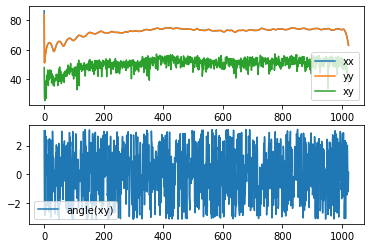

In [118]:
# Take more data. This time file is: guppi_59808_42208_101363318359_tmc_row1_6_0001.0000.raw
read_and_plot('/home/jackh/guppi_59808_42208_101363318359_tmc_row1_6_0001.0000.raw')

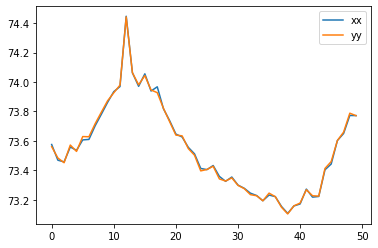

In [125]:
read_and_plot('/home/jackh/guppi_59808_42208_101363318359_tmc_row1_6_0001.0000.raw', include_xy=False, start_chan=500, stop_chan=550)

X max in channel 563
Y max in channel 512
Bin offset: 51
Freq offset: 99.6 kHz (resolution 1.95 kHz)


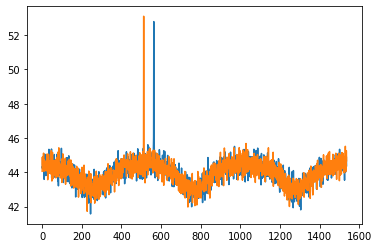

In [147]:
x, y = read_raw('/home/jackh/guppi_59808_42208_101363318359_tmc_row1_6_0001.0000.raw')
upchan_factor = 512
xup = upchan(x[511:514,:], upchan_factor)
yup = upchan(y[511:514,:], upchan_factor)
xdb = 10*np.log10(np.abs(xup).sum(axis=1))
ydb = 10*np.log10(np.abs(yup).sum(axis=1))

xmaxi = np.argmax(xdb)
ymaxi = np.argmax(ydb)
print('X max in channel %d' % xmaxi)
print('Y max in channel %d' % ymaxi)
delta_bin = xmaxi - ymaxi
rbw = 1e6 / upchan_factor # Hz
delta_f = delta_bin * rbw
print('Bin offset: %d' % delta_bin)
print('Freq offset: %.1f kHz (resolution %.2f kHz)' %(delta_f/1e3, rbw/1e3))
plt.plot(xdb)
plt.plot(ydb)